新增一筆資料

In [ ]:
# 添加一筆資料
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"  # Neo4j Bolt URL
username = "neo4j"
password = "sam112233"

# 連接到數據庫
driver = GraphDatabase.driver(uri, auth=(username, password))

def add_person(tx, name):
    query = (
        "CREATE (p:Person {name: $name}) "
        "RETURN p"
    )
    return tx.run(query, name=name).single()[0]

# 新增節點
with driver.session() as session:
    person = session.write_transaction(add_person, "Alice3")
    print(f"Created: {person['name']}")

# 關閉數據庫連接
driver.close()


`查詢資料`

In [ ]:
# 查詢資料
def find_person(tx, name):
    query = (
        "MATCH (p:Person {name: $name}) "
        "RETURN p.name AS name"
    )
    result = tx.run(query, name=name).single()
    return result["name"] if result else "No such person found"

# 查詢節點
with driver.session() as session:
    person_name = session.read_transaction(find_person, "Alice2")
    print(f"Found: {person_name}")


建立多筆具有關係的資料

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"  # Neo4j Bolt URL
username = "neo4j"
password = "sam112233"

# 連接到資料庫
driver = GraphDatabase.driver(uri, auth=(username, password))


def add_people_and_relationships(tx):
    # 建立多個人物節點和它們之間的關係
    query = """
        CREATE (a:Person {name: 'Alice'})
        CREATE (b:Person {name: 'Bob'})
        CREATE (c:Person {name: 'Carol'})
        CREATE (d:Person {name: 'Dave'})
        CREATE (e:Person {name: 'Eve'})
        
        CREATE (a)-[:FRIENDS_WITH]->(b)
        CREATE (a)-[:COLLEAGUES_WITH]->(c)
        CREATE (b)-[:FRIENDS_WITH]->(d)
        CREATE (c)-[:COLLEAGUES_WITH]->(d)
        CREATE (d)-[:FRIENDS_WITH]->(e)
        CREATE (e)-[:COLLEAGUES_WITH]->(a)
        
        RETURN a, b, c, d, e
    """
    results = tx.run(query)
    return results.single()  # Return the created nodes


# 運行事務並列印結果
with driver.session() as session:
    people = session.write_transaction(add_people_and_relationships)
    print("Created the following nodes:")
    for person in people:
        print(f"Created: {person['name']}")

# 關閉資料庫連接
driver.close()

透過添加關係和節點束性來建立多個人物節點間的多種關係

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

# 連接到資料庫
driver = GraphDatabase.driver(uri, auth=(username, password))

def add_people_and_complex_relationships(tx):
    # 透過添加關係和節點束性來建立多個人物節點間的多種關係
    query = """
    CREATE (a:Person {name: 'Alice', age: 30, occupation: 'Engineer'})
    CREATE (b:Person {name: 'Bob', age: 25, occupation: 'Designer'})
    CREATE (c:Person {name: 'Carol', age: 33, occupation: 'Manager'})
    CREATE (d:Person {name: 'Dave', age: 45, occupation: 'Developer'})
    CREATE (e:Person {name: 'Eve', age: 29, occupation: 'Analyst'})
    
    CREATE (a)-[:FRIENDS_WITH {since: 2020}]->(b)
    CREATE (a)-[:COLLEAGUES_WITH {since: 2018}]->(c)
    CREATE (b)-[:FRIENDS_WITH {since: 2021}]->(d)
    CREATE (c)-[:COLLEAGUES_WITH {since: 2019}]->(d)
    CREATE (d)-[:FRIENDS_WITH {since: 2019}]->(e)
    CREATE (e)-[:COLLEAGUES_WITH {since: 2021}]->(a)
    CREATE (a)-[:MENTOR_OF {since: 2022}]->(e)
    CREATE (b)-[:WORKS_WITH {on: 'Project X'}]->(c)
    CREATE (d)-[:LIVES_NEAR {distance: '5km'}]->(b)
    
    RETURN a, b, c, d, e
    """
    results = tx.run(query)
    # 傳回創建的節點和關係
    return results.single()

# 運行並輸出結果
with driver.session() as session:
    entities = session.write_transaction(add_people_and_complex_relationships)
    print("Created the following nodes and relationships:")
    for entity in entities:
        print(f"Created: {entity['name']} with attributes {dict(entity)}")

# 關閉資料庫連接
driver.close()


模擬文獻回顧

In [ ]:
import random
from neo4j import GraphDatabase

# Neo4j Bolt URL
uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

driver = GraphDatabase.driver(uri, auth=(username, password))

def create_keyword(tx, keyword):
    query = (
        "MERGE (k:Keyword {name: $name}) "
        "RETURN k"
    )
    return tx.run(query, name=keyword).single()[0]

def create_paper_with_keywords(tx, title, keywords):
    create_paper_query = (
        "CREATE (p:Paper {title: $title}) "
        "RETURN p"
    )
    paper_node = tx.run(create_paper_query, title=title).single()[0]
    
    for keyword in keywords:
        create_relationship_query = (
            "MATCH (p:Paper {title: $title}), (k:Keyword {name: $keyword}) "
            "MERGE (p)-[:HAS_KEYWORD]->(k)"
        )
        tx.run(create_relationship_query, title=title, keyword=keyword)
    return paper_node

def simulate_literature_review():
    keywords = ['machine learning', 'data mining', 'artificial intelligence', 
                'neural networks', 'deep learning', 'big data', 'natural language processing',
                'computer vision', 'bioinformatics', 'blockchain']
    papers = {f"Paper {i}": random.sample(keywords, k=random.randint(2, 5)) for i in range(1, 101)}

    with driver.session() as session:
        # Ensure all keywords exist in the database
        for keyword in set(sum(papers.values(), [])):
            session.write_transaction(create_keyword, keyword)
        
        # Create papers and their relationships to keywords
        for title, paper_keywords in papers.items():
            session.write_transaction(create_paper_with_keywords, title, paper_keywords)

if __name__ == "__main__":
    simulate_literature_review()
    print("Simulation of literature review data completed successfully.")
    driver.close()


在本地繪製

從Neo4j資料庫中提取關鍵字及其與文獻的關係數據，然後根據關鍵字出現的次數來調整節點的大小。

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase

# Neo4j Bolt URL
uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

driver = GraphDatabase.driver(uri, auth=(username, password))

def fetch_data(tx):
    # 查询关键字和与其相关的文献数量
    query = """
    MATCH (k:Keyword)<-[:HAS_KEYWORD]-(p:Paper)
    RETURN k.name AS keyword, COUNT(p) AS papers
    """
    return list(tx.run(query))

def plot_keywords_graph(data):
    G = nx.Graph()
    for record in data:
        keyword, weight = record['keyword'], record['papers']
        G.add_node(keyword, size=weight)
    
    # 添加节点之间的边（这里假设是示例，实际需要根据实际数据调整）
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            G.add_edge(data[i]['keyword'], data[j]['keyword'])
    
    pos = nx.spring_layout(G)  # 使用Spring布局
    sizes = [G.nodes[node]['size'] * 100 for node in G]  # 调整节点大小

    # 绘制节点
    nx.draw(G, pos, with_labels=True, node_size=sizes, node_color='lightblue', edge_color='gray')
    
    # 显示图形
    plt.title('Keyword Co-occurrence Graph')
    plt.show()

with driver.session() as session:
    keyword_data = session.read_transaction(fetch_data)
    plot_keywords_graph(keyword_data)

driver.close()


修正顯示

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase

# Neo4j Bolt URL
uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

driver = GraphDatabase.driver(uri, auth=(username, password))

def fetch_data(tx):
    # 查询关键字和与其相关的文献数量
    query = """
    MATCH (k:Keyword)<-[:HAS_KEYWORD]-(p:Paper)
    RETURN k.name AS keyword, COUNT(p) AS papers
    """
    return list(tx.run(query))

def plot_keywords_graph(data):
    G = nx.Graph()
    for record in data:
        keyword, weight = record['keyword'], record['papers']
        G.add_node(keyword, size=weight)
    
    # 添加节点之间的边（这里假设是示例，实际需要根据实际数据调整）
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            G.add_edge(data[i]['keyword'], data[j]['keyword'])
    
    pos = nx.spring_layout(G)  # 使用Spring布局
    sizes = [G.nodes[node]['size'] * 100 for node in G]  # 调整节点大小

    # 打印关键词及其文献数量
    print("Keyword and their respective number of papers:")
    for record in data:
        print(f"{record['keyword']}: {record['papers']}")

    # 绘制节点
    nx.draw(G, pos, with_labels=True, node_size=sizes, node_color='lightblue', edge_color='gray')
    
    # 显示图形
    plt.title('Keyword Co-occurrence Graph')
    plt.show()

with driver.session() as session:
    keyword_data = session.read_transaction(fetch_data)
    plot_keywords_graph(keyword_data)

driver.close()


加入顏色

/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_499/447329250.py:52: DeprecationWarning: read_transaction has been renamed to execute_read
  keyword_data = session.read_transaction(fetch_data)


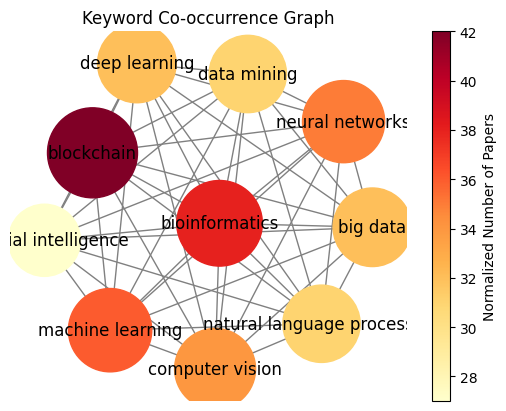

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import numpy as np

# Neo4j Bolt URL
uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

driver = GraphDatabase.driver(uri, auth=(username, password))

def fetch_data(tx):
    # 查询关键字和与其相关的文献数量
    query = """
    MATCH (k:Keyword)<-[:HAS_KEYWORD]-(p:Paper)
    RETURN k.name AS keyword, COUNT(p) AS papers
    """
    return list(tx.run(query))

def plot_keywords_graph(data):
    G = nx.Graph()
    papers_counts = [record['papers'] for record in data]
    min_papers = min(papers_counts)
    max_papers = max(papers_counts)

    for record in data:
        keyword, weight = record['keyword'], record['papers']
        G.add_node(keyword, size=weight, count=weight)
    
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            G.add_edge(data[i]['keyword'], data[j]['keyword'])
    
    pos = nx.spring_layout(G)
    sizes = [G.nodes[node]['size'] * 100 for node in G]
    normalized_counts = [(G.nodes[node]['count'] - min_papers) / (max_papers - min_papers) for node in G]
    cmap = plt.get_cmap('YlOrRd')
    norm = plt.Normalize(vmin=min_papers, vmax=max_papers)

    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_size=sizes, node_color=normalized_counts, cmap=cmap, edge_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Normalized Number of Papers')

    plt.title('Keyword Co-occurrence Graph')
    plt.show()

with driver.session() as session:
    keyword_data = session.read_transaction(fetch_data)
    plot_keywords_graph(keyword_data)

driver.close()


將大小的比例進行優化

/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_499/2600332151.py:59: DeprecationWarning: read_transaction has been renamed to execute_read
  keyword_data = session.read_transaction(fetch_data)


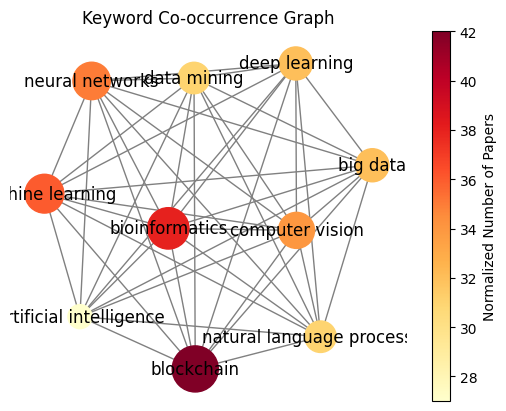

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import numpy as np

# Neo4j Bolt URL
uri = "bolt://localhost:7687"
username = "neo4j"
password = "sam112233"

driver = GraphDatabase.driver(uri, auth=(username, password))

def fetch_data(tx):
    # 查询关键字和与其相关的文献数量
    query = """
    MATCH (k:Keyword)<-[:HAS_KEYWORD]-(p:Paper)
    RETURN k.name AS keyword, COUNT(p) AS papers
    """
    return list(tx.run(query))

def plot_keywords_graph(data):
    G = nx.Graph()
    papers_counts = [record['papers'] for record in data]
    min_papers = min(papers_counts)
    max_papers = max(papers_counts)

    # Calculate size factor based on the range of paper counts
    base_size = 300  # Base size for the smallest node
    size_range = 800  # Additional size for the largest node

    for record in data:
        keyword, weight = record['keyword'], record['papers']
        # Normalize weight and apply scaling factor
        normalized_weight = (weight - min_papers) / (max_papers - min_papers)
        scaled_size = base_size + normalized_weight * size_range
        G.add_node(keyword, size=scaled_size, count=weight)
    
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            G.add_edge(data[i]['keyword'], data[j]['keyword'])
    
    pos = nx.spring_layout(G)
    sizes = [G.nodes[node]['size'] for node in G]  # Use calculated size
    normalized_counts = [(G.nodes[node]['count'] - min_papers) / (max_papers - min_papers) for node in G]
    cmap = plt.get_cmap('YlOrRd')
    norm = plt.Normalize(vmin=min_papers, vmax=max_papers)

    fig, ax = plt.subplots()
    nx.draw(G, pos, ax=ax, with_labels=True, node_size=sizes, node_color=normalized_counts, cmap=cmap, edge_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Normalized Number of Papers')

    plt.title('Keyword Co-occurrence Graph')
    plt.show()

with driver.session() as session:
    keyword_data = session.read_transaction(fetch_data)
    plot_keywords_graph(keyword_data)

driver.close()
